In [1]:
import numpy as np
import awkward as ak
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mtpl
import shutil

import sys,os
import uproot4

from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
sys.path.append("/home/uzh/sbuse/1_MT/experimental_rate/argon_reanalysis/helpers")
from square_plotting import colorbar

import numericalunits as nu


def flat(array):
    return np.array(ak.flatten(array))

def percent(total,x,decimals=1):
    "calculate the percentage of x w.r.t total"
    return np.round_(100/total*np.sum(x),decimals)


In [2]:
saving_path= "/disk/data8/student/sbuse/megatrees_without_splitting/"
complete_megatrees = []

for entry in os.scandir(saving_path+"3.00kV_BG/"):
    if (entry.path.startswith(saving_path+"3.00kV_BG/megatree_complete_")):
        complete_megatrees.append(entry.path+":t1")

complete_megatrees.sort()
complete_megatrees = complete_megatrees
len(complete_megatrees)

61

In [3]:
stable = ["191029_1025","191031_0505","191101_2340","191102_0258","191102_0616",
          "191102_0936","191102_2024","191102_2335","191106_0250","191106_0605"]

stable_names=[]
for i,name in enumerate(complete_megatrees): 
    if name[-19:-8] in stable:
        stable_names.append(name)
complete_megatrees=stable_names

## read the out the measurement time

In [4]:
import uproot 
date = [i[-19:-8] for i in complete_megatrees]
time_sec =0
total_meas_waves = 0 

for i in date:
    print(i)
    prepro = uproot.lazy("/disk/bulk_atp/thiemek/XurichII/processed_without_splitting/Run3/processed_{}.root:T1".format(i))
    measurement_time = prepro.Time[-1] - prepro.Time[0]
    time_sec += measurement_time
    total_meas_waves += prepro.EventNumber[-1]-prepro.EventNumber[0]

time_sec = time_sec*nu.s
print(time_sec/nu.hour)
print(total_meas_waves)

191029_1025
191031_0505
191101_2340
191102_0258
191102_0616
191102_0936
191102_2024
191102_2335
191106_0250
191106_0605
30.216111111111115
4628959


In [5]:
time_sec/nu.hour

30.216111111111115

## Load events and apply noise cuts 

In [6]:
events = ak.Array([]) 
batch_count = 0
files = []
loaded_waveforms = 0
rm_preceding_sat = 0
rm_noisy_pmt     = 0 
rm_width         = 0 
rm_too_many_p    = 0
rm_large_s2_bft  = 0

for batch,report in uproot4.iterate(complete_megatrees,how="zip",report=True):
    
    files.append(report.file.file_path[-16:-5])
    batch["file"] = report.file.file_path[-16:-5]
    loaded_waveforms += len(batch)
    
    #Preselection
    #---------------Waveform level----------------
    #Satration cut
    s2  = ak.all(batch.s2.height_mvdc_bot<1.6*1e3, axis=1)
    s1  = ak.all(batch.s1.height_mvdc_bot<1.6*1e3, axis=1)
    batch= batch[s2 & s1]
    
    #remove waveform that are directly after a saturated event
    rm_preceding_sat += np.sum(batch.preceding_is_sat)
    batch = batch[np.invert(batch.preceding_is_sat)]
    
    
    #remove waveforms were the pmt was noisy
    rm_noisy_pmt += np.sum(np.invert(batch.npulses_pmt<15))
    batch = batch[batch.npulses_pmt<15]
    
    #Cut all waveforms that have a very wide peak--> wired stuff
    rm_width += ak.sum(np.invert(ak.all(batch.s2.width_bot<300,axis=1)))
    rm_width += ak.sum(np.invert(ak.all(batch.s1.width_bot<300,axis=1)))
    batch=batch[ak.all(batch.s2.width_bot<300,axis=1)]
    batch=batch[ak.all(batch.s1.width_bot<300,axis=1)]

    
#     #cut waveforms with to many peaks. 
#     rm_too_many_p += np.sum(np.invert(batch.s2s_per_waveform<10))
#     batch = batch[batch.s2s_per_waveform<10]
    
#     #cut all waveforms that have a s2 larger than 500 before the trigger
#     mask= np.invert(ak.any((np.abs(batch.s2.area_pe_bot+batch.s2.area_pe_top)>500)&(batch.s2.pos_bot<2990),axis=1))
#     rm_large_s2_bft += np.sum(np.invert(mask))
#     batch = batch[mask]
   
   
    #---------------Add pulse variables----------------    
    batch["s2","r"] = (batch.s2.x_corr**2+batch.s2.y_corr**2)**0.5
    batch["s2","frt"] = batch.s2.area_pe_top/(batch.s2.area_pe_top+batch.s2.area_pe_bot)
     
    events = ak.concatenate([events,batch])

files = np.array(files)
n_files = len(np.unique(files))

In [7]:
print("preceding is sat        : "+str(percent(loaded_waveforms,rm_preceding_sat))+ " %")
print("noisy pmt               : "+str(percent(loaded_waveforms,rm_noisy_pmt))+ " %")
print("width cut               : "+str(percent(loaded_waveforms,rm_width))+" %")
# print("too many S2s           : "+str(percent(loaded_waveforms,rm_too_many_p))+" %")
# print("large S2 before trigger : "+str(percent(loaded_waveforms,rm_large_s2_bft))+" %")
print("-------------------------------")
print("total removed           : "+str(100-percent(loaded_waveforms,len(events)))+" %" )

preceding is sat        : 25.2 %
noisy pmt               : 21.2 %
width cut               : 2.1 %
-------------------------------
total removed           : 48.5 %


In [8]:
loaded_waveforms,len(events)

(1259430, 648167)

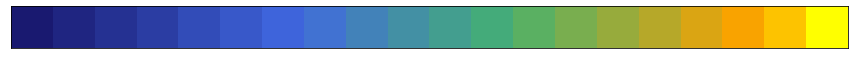

In [9]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors

c=mcolors.ColorConverter().to_rgb
#bb = [(0,c("midnightblue")),(0.29,c("royalblue")),(0.58,c("tab:green")),(0.9,(0.98, 0.64, 0.0)),(0.96,c("gold")),(1,c("yellow"))]
bb = [(0,c("midnightblue")),(0.33,c("royalblue")),(0.6,(0.27, 0.70, 0.44)),(0.9,(0.98, 0.64, 0.0)),(0.98,c("gold")),(1,c("yellow"))]
my_colors = LinearSegmentedColormap.from_list( 'my_colors',bb,100)
plt.register_cmap(cmap=my_colors)

plt.figure( figsize = (15,3))
plt.imshow( [list(np.arange(0,2, 0.1)) ] , interpolation='nearest', origin='lower', cmap= "my_colors" )
plt.xticks([])
plt.yticks([])
plt.show()


# Overview of S2 features

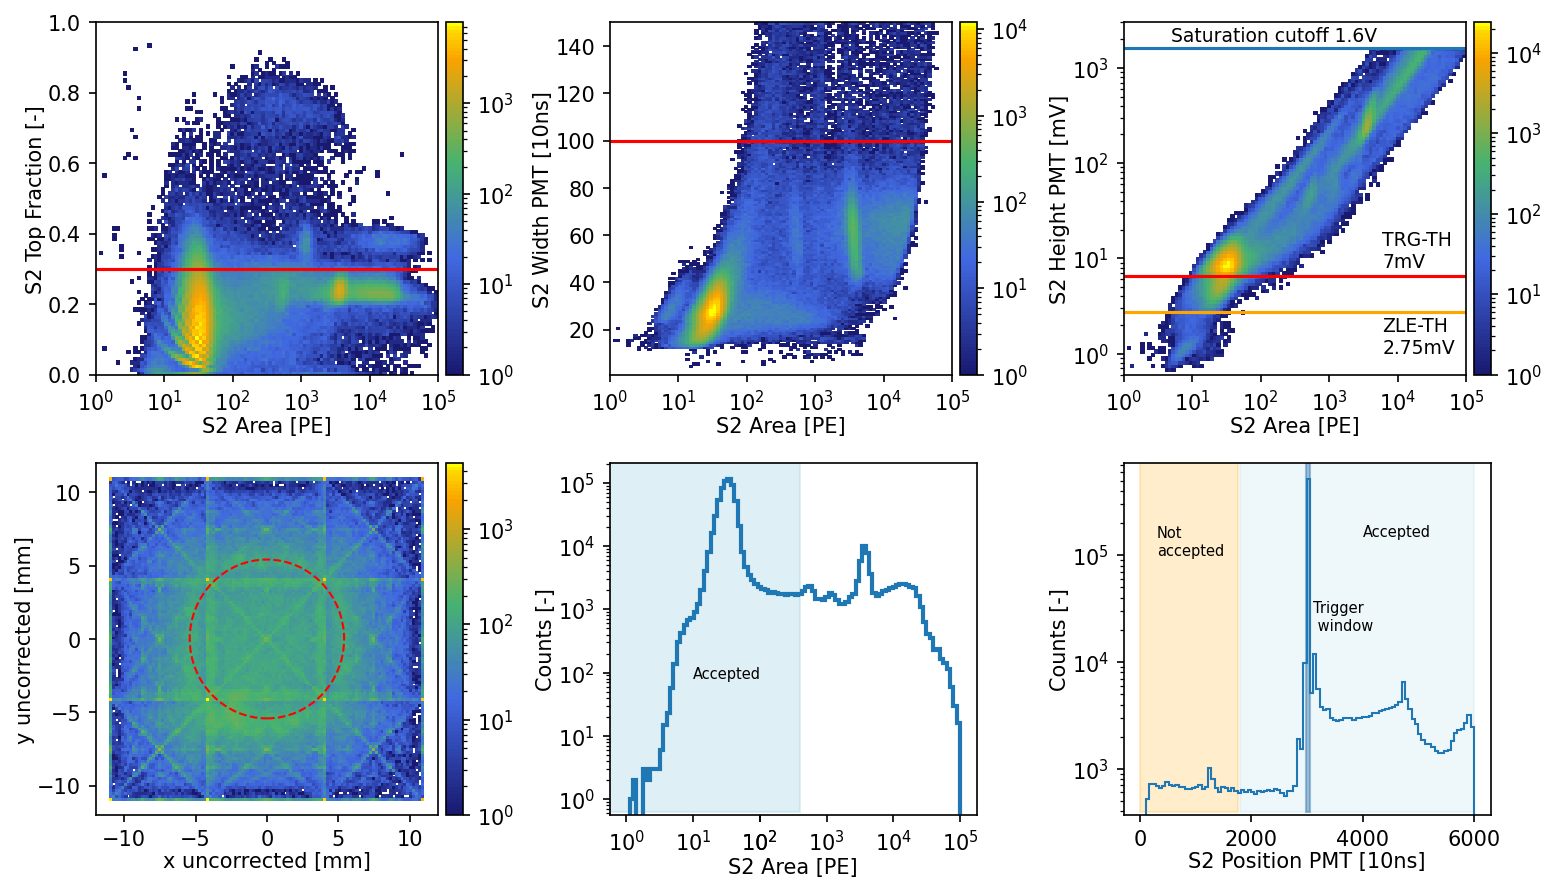

In [10]:
cmap_ = "my_colors"
import matplotlib as mplt

f, axes = plt.subplots(2, 3,figsize=(12,7), dpi=150)
s2_low = 1
s2_up = 1e5
lines=True

s2_area = flat(events.s2.area_pe_bot+events.s2.area_pe_top)
s2_frt= flat(events.s2.frt)

_,_,_,img = axes[0][0].hist2d(s2_area[s2_area<s2_up],s2_frt[s2_area<s2_up],
                       range=[[s2_low,s2_up],[0,1]],cmap=cmap_,
                       bins=(np.geomspace(s2_low,s2_up,num=100),100),norm=LogNorm())
axes[0][0].set_xlabel(r"S2 Area [PE]",labelpad=1)
axes[0][0].set_ylabel("S2 Top Fraction [-]",labelpad=1)
if lines:
    axes[0][0].hlines(0.30,s2_low,s2_up,color="red")
# axes[0][0].text(1.5,0.32,"Selection",fontsize=12,color="red")
#axes[0][0].set_ylim(0,0.35)
axes[0][0].set_xscale("log")
axes[0][0].set_xticks([1e0,1e1,1e2,1e3,1e4,1e5])
p=colorbar(img)



w_up = 150
w_low = 1
s2_width_bot = np.array(ak.flatten(events.s2.width_bot))
_,_,_,img = axes[0][1].hist2d(s2_area[s2_area<s2_up],s2_width_bot[s2_area<s2_up],
                       range=[[s2_low,s2_up],[w_low,w_up]],cmap=cmap_,
                       bins=(np.geomspace(s2_low,s2_up,100),np.linspace(w_low,w_up,w_up-w_low)),
                       norm=LogNorm())
p=colorbar(img)
if lines:
    axes[0][1].hlines(100,s2_low,s2_up, color="red")
# axes[0][1].text(1.5,105,"Selection",fontsize=11,color="red")

#p.set_label(r'Counts', rotation=90)  
axes[0][1].set_xlabel(r"S2 Area [PE]",labelpad=1)
axes[0][1].set_ylabel("S2 Width PMT [10ns]",labelpad=1)
axes[0][1].set_xscale("log")
axes[0][1].set_xticks([1e0,1e1,1e2,1e3,1e4,1e5])
#axes[0][1].set_yscale("log")

h_low=0.6
h_up=3e3
_,_,_,img = axes[0][2].hist2d(s2_area,flat(events.s2.height_mvdc_bot),cmap=cmap_,
                       bins=(np.geomspace(s2_low,s2_up,num=100),
                             np.geomspace(h_low,h_up,num=100)),norm=LogNorm())
if lines:
    axes[0][2].hlines(1.6*1e3,s2_low,s2_up)
    axes[0][2].text(5,1.9*1e3,"Saturation cutoff 1.6V", fontsize=9)

    axes[0][2].hlines(6.6,s2_low,s2_up, color="red")
    axes[0][2].text(6e3,8,"TRG-TH\n7mV", fontsize=9)

    axes[0][2].hlines(2.75,s2_low,s2_up, color ="orange" )
    axes[0][2].text(6e3,1,"ZLE-TH\n2.75mV", fontsize=9)

axes[0][2].set_xlabel(r"S2 Area [PE]",labelpad=1)
axes[0][2].set_ylabel("S2 Height PMT [mV]",labelpad=1)
axes[0][2].set_xscale("log")
axes[0][2].set_yscale("log")
axes[0][2].set_xticks([1e0,1e1,1e2,1e3,1e4,1e5])
p=colorbar(img)

_,_,_,img = axes[1][0].hist2d(flat(events.s2.x_uncorr),flat(events.s2.y_uncorr),cmap=cmap_,
                              range=[[-12,12],[-12,12]],bins=(120,120),norm=LogNorm())

p=colorbar(img)
axes[1][0].set_xlabel(r"x uncorrected [mm]",labelpad=1)
axes[1][0].set_ylabel("y uncorrected [mm]",labelpad=1)
# axes[1][0].legend()
if lines:
    circ1 = mplt.patches.Circle((0,0),5.41,fill = False, linestyle="--", color ="red",label="selection")
    axes[1][0].add_patch(circ1)

    

    
axes[1][1].hist(flat(events.s2.area_pe_bot+events.s2.area_pe_top),
             bins=np.geomspace(s2_low,s2_up,num=100), histtype="step",linewidth=2)
if lines:
    axes[1][1].axvspan(0, 400, alpha=0.4,ymin=0.01, ymax=1 ,color='lightblue') 
    axes[1][1].text(10,80,"Accepted", fontsize=7)

axes[1][1].set_xlabel(r"S2 Area [PE]",labelpad=1)
axes[1][1].set_ylabel("Counts [-]",labelpad=1)
axes[1][1].set_yscale("log")
axes[1][1].set_xscale("log")
axes[1][1].set_xticks([1e0,1e1,1e2,1e2,1e3,1e4,1e5])

axes[1][2].hist(flat(events.s2.pos_bot),bins=100, histtype="step")
axes[1][2].set_yscale("log")
axes[1][2].set_xlabel("S2 Position PMT [10ns]",labelpad=1)
axes[1][2].set_ylabel("Counts [-]",labelpad=1)
if lines:
    axes[1][2].axvspan(0, 1750, alpha=0.2,ymin=0.01, ymax=1 ,color='orange') 
    axes[1][2].text(300,1e5,"Not\naccepted", fontsize=7)

    axes[1][2].axvspan(1800, 6000, alpha=0.2,ymin=0.01, ymax=1 ,color='lightblue') 
    axes[1][2].text(4000,1.5e5,"Accepted", fontsize=7)

    axes[1][2].axvspan(2980,3050, alpha=0.5,ymin=0.01, ymax=1 ,color='steelblue') 
    axes[1][2].text(3100,2e4,"Trigger\n window", fontsize=7)

# axes[0][0].text(1,1.1, "Background with stable trigger-rate, peak splitting OFF"+ 
#                 "\n{}x files at 3.00kV, {:.1f}d measurement time,".format(n_files,time_sec/nu.day)+ 
#                 "{:.1E} selected waveforms".format(len(events)), fontsize=12)

plt.subplots_adjust(wspace=0.4, hspace=0.25)
plt.show()

## Event selection

In [11]:
%%writefile /home/uzh/sbuse/1_MT/experimental_rate/rates/functions/rate_selection3.py
import numba as nb
import numpy as np
import awkward as ak
import numericalunits as nu

def percent(total,x,decimals=1):
    "calculate the percentage of x w.r.t total"
    return np.round_(100/np.sum(total)*np.sum(x),decimals)

def pulse_level_cut(batch):
    batch = ak.Array(batch)
  
    #cut all pulses outside 10mm
    batch["s2"] = batch.s2[batch["s2","r"]<10]
    
    #cut all pulses with large frt
    batch["s2"] = batch.s2[batch["s2","frt"]<0.29]
    
    #cut large widths
    batch["s2"] = batch.s2[batch.s2.width_bot<100]
    
    #cut pulses below minimal height
    batch["s2"] = batch.s2[batch.s2.height_mvdc_bot>=7.0]
    
#     #cut away the lower half
#     batch["s2"] = batch.s2[batch.s2.y_corr>0.]    
    
    #update the number of s2s
    batch["s2s_per_waveform"] = ak.num(batch.s2.area_pe_bot,axis=1)
    
    #remove the waveforms which don't have any remaining s2s
    batch = batch[batch.s2s_per_waveform>0]
    return batch

 
@nb.jit(nopython=True)
def check_dist2(veto_pos,s2_pos,se_ind,dt):
    good_pulses = [False]*len(s2_pos)
    if len(se_ind)>0:
        for i in se_ind: #loop over candidates
            diff = veto_pos-s2_pos[i]
            before = diff < -dt
            after  = diff > 0
            # Question: Are all vetos before or after the s2? 
            # -> save answer: True (good) or False (time veto)
            good_pulses[i] = np.all((before)|(after))
    return good_pulses 

def rate_selection(events,dt=1750):
    """Selects the good pulses in events. The final selection can be accessed by 
    events.s2.feature[events.s2.final_selection], The order of the cuts is important we want to 
    first check time correlation and the later remove the wall events"""
    
    df = ak.Array(events)
  
    #create a parent label
    df["s2","parent"] = (df.s2.area_pe_bot+df.s2.area_pe_top)>400 
    df["s2","se_candidate"] = np.invert(df.s2.parent)&(df.s2.r<10)&(df.s2.frt<0.29)&(df.s2.width_bot<100)&(df.s2.height_mvdc_bot>=7.0)
    
    #remove all the waveforms which only have one S2 and it is a parent. 
    lone_p = (ak.sum(df.s2.parent,axis=1)==1)&(df.s2s_per_waveform==1)
    t_veto_p = ak.sum(6000-(df.s2.pos_bot[lone_p]))
    df = df[np.invert(lone_p)]
   
    # 1)---------One S2 in the waveform.--------> only need to check there is no S1 before
    one_s2 = ak.Array(df[df.s2s_per_waveform==1])
    one_s2["label"] = np.array(["one_s2"]*len(one_s2))
    after = one_s2.s1.pos_bot-ak.flatten(one_s2.s2.pos_bot)>0 # s1 after the s2
    before = one_s2.s1.pos_bot-ak.flatten(one_s2.s2.pos_bot)<-dt # s1 more than 1750 before the s2

    #select the s2s were the conditions is true for all on an induvidual level
    one_s2["s2","selection"] = (one_s2["s2","se_candidate"])&ak.all( before | after, axis =1)
    
        
    # 2) --------Multiple S2s in the waveform-----> need to check S1 and S2 positions relative to each other
    multi_s2 = ak.Array(df[df.s2s_per_waveform>1])

    # No S1 before, loop over all waveforms and se candidates to check the distance to the s1s
    no_s1 = [None]*len(multi_s2)

    s2_pos   = multi_s2.s2.pos_bot
    s1_pos   = multi_s2.s1.pos_bot
    A = multi_s2.s2.se_candidate
    # find the index [0,1,2] where the se candidate is
    se_ind = ak.where(A, ak.local_index(A), ak.broadcast_arrays(A, -1)[1])
    se_ind = se_ind[se_ind != -1]

    for i in range(len(s2_pos)):
        no_s1[i]=check_dist2(np.array(s1_pos[i]),np.array(s2_pos[i]),np.array(se_ind[i]),dt)
                
    multi_s2["s2","no_s1"] = ak.Array(no_s1)
    
    #count the number of pulses which don't have an s1 before them.
    n_no_s1 = np.sum(one_s2["s2","selection"])+np.sum(multi_s2["s2","no_s1"])
    
    # 2.1)----------Multiple S2s and at least one Parent------> check the positions to the s2s as well
    # the s2 must be before the parent. If it is after the parent nothing is selected anymore dt=6000. 
    
    multi_s2_wp = ak.Array(multi_s2[ak.any(multi_s2["s2","parent"],axis=1)])
    multi_s2_wp["label"] = np.array(["multi_s2_with_parent"]*len(multi_s2_wp))
    
    no_p_before =[None]*len(multi_s2_wp)

    s2_pos   = multi_s2_wp.s2.pos_bot
    s2_pos_p = s2_pos[multi_s2_wp.s2.parent]
    A = multi_s2_wp.s2.se_candidate
    # find the index [0,1,2] where the se candidate is
    se_ind = ak.where(A, ak.local_index(A), ak.broadcast_arrays(A, -1)[1])
    se_ind = se_ind[se_ind != -1]

    for i in range(len(s2_pos)):
        no_p_before[i]=check_dist2(np.array(s2_pos_p[i]),np.array(s2_pos[i]),np.array(se_ind[i]),6000)
    
    no_p_before = ak.Array(no_p_before)
    multi_s2_wp["s2","selection"]=(no_p_before)&(multi_s2_wp["s2","no_s1"])&(multi_s2_wp["s2","se_candidate"])
    
    #the amount of time vetoed:
    t_vetoed = ak.sum(6000-ak.min(multi_s2_wp.s2.pos_bot[multi_s2_wp.s2.parent],axis=1))+t_veto_p
    
    # 2.2)----------Multiple S2s and no Parent------> don't need to check s2s position
    multi_s2_np = ak.Array(multi_s2[np.invert(ak.any(multi_s2["s2","parent"],axis=1))])
    multi_s2_np["label"] = np.array(["multi_s2_no_parent"]*len(multi_s2_np))
    
    multi_s2_np["s2","selection"]=(multi_s2_np["s2","no_s1"])&(multi_s2_np["s2","se_candidate"])
    
    #count the number of pulses which don't have a large s2 before them.
    n_no_s2 = np.sum(one_s2["s2","selection"])+np.sum(no_p_before)+np.sum(np.invert(multi_s2_np["s2","parent"]))
    

    #---------------Pulse level cutting (needs to be here!)----------------
    one_s2      = pulse_level_cut(one_s2)
    multi_s2_wp = pulse_level_cut(multi_s2_wp)
    multi_s2_np = pulse_level_cut(multi_s2_np)
        

    # add all together
    final = ak.concatenate((one_s2,multi_s2_wp,multi_s2_np),axis=0,merge=True,highlevel=True)
    

    #remove all the waveforms which only have one S2 and it is a parent. 
    final = final[np.invert((ak.sum(final.s2.parent,axis=1)==1)&(final.s2s_per_waveform==1))]
    
    n_tot = np.sum(final.s2.selection)
    
    print("------------------------------")
    print("Total selected pulses  : {} ".format(n_tot))
    print("   one_s2              : "+str(np.sum(one_s2.s2.selection))
          +" , "+str(percent(n_tot,one_s2.s2.selection))+ "%")

    print("   all s2 small        : "+str(np.sum(multi_s2_np.s2.selection))
          +" , "+str(percent(n_tot,multi_s2_np.s2.selection))+ "%")
    
    print("   one big S2 present  : "+str(np.sum(multi_s2_wp.s2.selection))
          +" , "+str(percent(n_tot,multi_s2_wp.s2.selection))+ "%")
    
    print("------------------------------")

#     in_tw= (final.s2.pos_bot>=2990)&(final.s2.pos_bot<3013)
#     final["s2","final_selection"] = (final["s2","selection"])&in_tw
#     final["s2","not_accepted"]  = (final["s2","selection"])&np.invert(in_tw)
    
    final["s2","final_selection"] = (final["s2","selection"])&(final.s2.pos_bot>dt)
    final["s2","not_accepted"]  = (final["s2","selection"])&(final.s2.pos_bot<dt)
    f_not_acc = 1/np.sum(final.s2.selection)*np.sum(final.s2.not_accepted)

    
    print("Num pulses accepted      : "+str(np.sum(final.s2.final_selection))+" , "+
          str(percent(final.s2.selection,final.s2.final_selection))+ " %")
    print("Num pulses not accepted   : "+str(np.sum(final.s2.not_accepted))+" , "+
          str(percent(final.s2.selection,final.s2.not_accepted))+ " %")
    print("------------------------------")
    
    return final,n_no_s1,n_no_s2,f_not_acc,t_vetoed


Overwriting /home/uzh/sbuse/1_MT/experimental_rate/rates/functions/rate_selection3.py


In [12]:
sys.path.append("/home/uzh/sbuse/1_MT/experimental_rate/rates/functions/")

In [13]:
%load_ext autoreload
%autoreload 2
from rate_selection3 import rate_selection

In [14]:
%%time
dt=1750
pulses,n_no_s1,n_no_s2,f_not_acc,t_vetoed = rate_selection(events,dt=dt)
pulses

------------------------------
Total selected pulses  : 118686 
   one_s2              : 112822 , 95.1%
   all s2 small        : 5457 , 4.6%
   one big S2 present  : 407 , 0.3%
------------------------------
Num pulses accepted      : 117984 , 99.4 %
Num pulses not accepted   : 701 , 0.6 %
------------------------------
CPU times: user 49.9 s, sys: 765 ms, total: 50.7 s
Wall time: 50.7 s


<Array [{s1s_per_waveform: 0, ... ] type='163791 * ?{"s1s_per_waveform": int32, ...'>

In [15]:
a= (events.s2.area_pe_bot+events.s2.area_pe_top<400)
tot_s2 = np.sum(events.s2.area_pe_bot+events.s2.area_pe_top<400)

print("S2<400PE         : "+str(percent(tot_s2,events.s2.area_pe_bot+events.s2.area_pe_top<400))+"%")
print("NO S1            : "+str(percent(tot_s2,n_no_s1))+"%")
print("NO S2            : "+str(percent(tot_s2,n_no_s2))+"%")
print("r<10             : "+str(percent(tot_s2,(events.s2.r<10)&a))+"%")
print("frt<0.29         : "+str(percent(tot_s2,(events.s2.frt<0.29)&a))+"%")
print("width<100 [10]ns : "+str(percent(tot_s2,(events.s2.width_bot<100)&a))+"%")
print("height>7 mV      : "+str(percent(tot_s2,(events.s2.height_mvdc_bot>=7.0)&a))+"%")
print("after dt         : "+str(percent(tot_s2,(events.s2.pos_bot>=dt)&a))+"%")
print("----------------------")
print("total            : "+str(percent(tot_s2,pulses.s2.final_selection))+"%")

S2<400PE         : 100.0%
NO S1            : 19.0%
NO S2            : 27.8%
r<10             : 32.2%
frt<0.29         : 95.2%
width<100 [10]ns : 99.5%
height>7 mV      : 84.0%
after dt         : 97.0%
----------------------
total            : 18.7%


# Overview of the selected events 

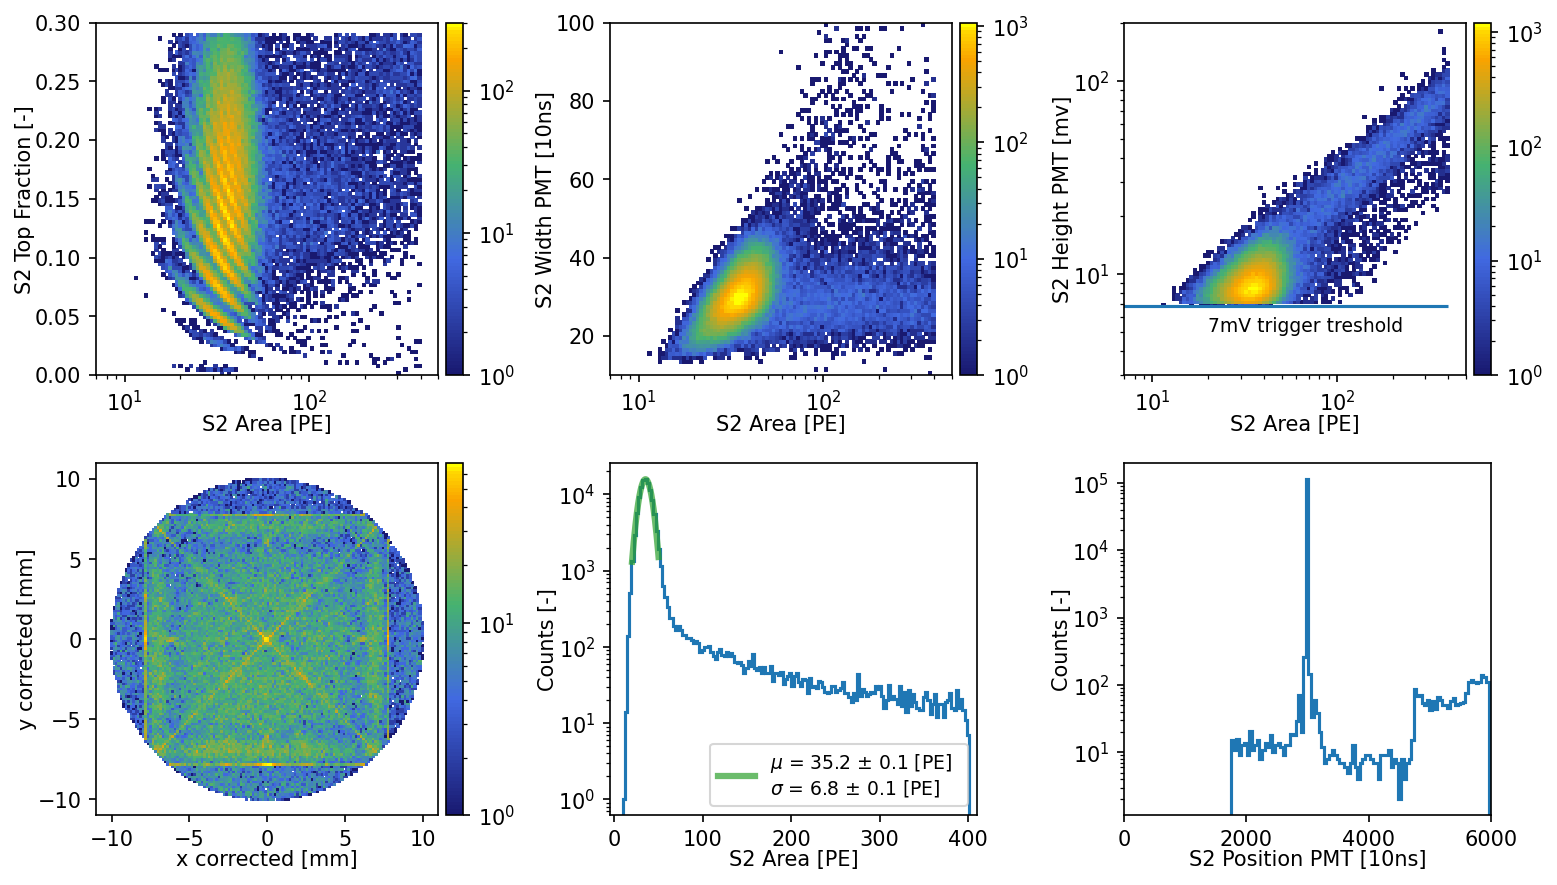

In [16]:
f, axes = plt.subplots(2, 3,figsize=(12,7), dpi=150)
s2_low = 7
s2_up = 500

s2_area = flat((pulses.s2.area_pe_bot+pulses.s2.area_pe_top)[pulses.s2.final_selection])
s2_frt= flat((pulses.s2.frt)[pulses.s2.final_selection])

_,_,_,img = axes[0][0].hist2d(s2_area,s2_frt,
                       range=[[s2_low,s2_up],[0,0.3]],cmap=cmap_,
                       bins=(np.geomspace(s2_low,s2_up,num=100),100),norm=LogNorm()) 
axes[0][0].set_xlabel(r"S2 Area [PE]",labelpad=0)
axes[0][0].set_ylabel("S2 Top Fraction [-]",labelpad=0)
#axes[0][0].set_ylim(0,0.35)
axes[0][0].set_xscale("log")
p=colorbar(img)



w_up = 100
w_low = 10
s2_width_bot = flat(pulses.s2.width_bot[pulses.s2.final_selection])
_,_,_,img = axes[0][1].hist2d(s2_area[s2_area<s2_up],s2_width_bot[s2_area<s2_up],cmap=cmap_,
                       bins=(np.geomspace(s2_low,s2_up,num=100),
                             np.linspace(w_low,w_up,num=w_up-w_low+1)),norm=LogNorm())
p=colorbar(img)
#p.set_label(r'Counts', rotation=90)  
axes[0][1].set_xlabel(r"S2 Area [PE]",labelpad=0)
axes[0][1].set_ylabel("S2 Width PMT [10ns]",labelpad=0)
axes[0][1].set_xscale("log")
#axes[0][1].set_yscale("log")

h_low=3
h_up=200
_,_,_,img = axes[0][2].hist2d(s2_area,flat(pulses.s2.height_mvdc_bot[pulses.s2.final_selection]),
                       bins=(np.geomspace(s2_low,s2_up,num=100),
                             np.geomspace(h_low,h_up,num=100)),norm=LogNorm(),cmap=cmap_,)
axes[0][2].hlines(6.8,0,400)
axes[0][2].text(20,5,"7mV trigger treshold", fontsize=9)
axes[0][2].set_xlabel(r"S2 Area [PE]",labelpad=0)
axes[0][2].set_ylabel("S2 Height PMT [mv]",labelpad=0)
axes[0][2].set_xscale("log")
axes[0][2].set_yscale("log")
p=colorbar(img)

_,_,_,img = axes[1][0].hist2d(flat(pulses.s2.x_corr[pulses.s2.final_selection]),
                              flat(pulses.s2.y_corr[pulses.s2.final_selection]),cmap=cmap_,
                              bins=(140,140),norm=LogNorm(), range=[[-11,11],[-11,11]])
axes[1][0].set_xlabel(r"x corrected [mm]",labelpad=0)
axes[1][0].set_ylabel("y corrected [mm]",labelpad=0)
p=colorbar(img)

h,bins,_ = axes[1][1].hist(s2_area,bins=np.linspace(s2_low,s2_up,num=200), histtype="step",linewidth=1.5)
axes[1][1].set_xlabel(r"S2 Area [PE]",labelpad=0)
axes[1][1].set_ylabel("Counts [-]",labelpad=0)
axes[1][1].set_yscale("log")
#axes[1][1].set_xscale("log")
axes[1][1].set_xlim(-5,410)

upper_end_peak = 50
lower_end_peak = 20
def func(x,*params):
    result = params[0]*np.exp(-0.5*((x-params[1])/(params[2]))**2)
    
    return result

xdata=np.array((bins+(bins[1]-bins[0])/2)[:-1])
ydata=h
init  = [max(h), bins[np.argmax(h)], 10]

a = xdata>lower_end_peak 
b = xdata<upper_end_peak

popt, pcov = curve_fit(func, xdata[a&b], ydata[a&b],p0=init)
perr = np.sqrt(np.diag(pcov))
x_plot = np.linspace(lower_end_peak, upper_end_peak,200)

axes[1][1].plot(x_plot, func(x_plot, *popt), linewidth=3, alpha =0.7, color="tab:green",
             label="$\mu$ = {:.1f} $\pm$ {:.1f} [PE]  \n$\sigma$ = {:.1f} $\pm$ {:.1f} [PE]".format(popt[1],perr[1],
                                                                                                    popt[2],perr[2]))

axes[1][1].legend(loc="lower right",fontsize=9)

axes[1][2].hist(flat(pulses.s2.pos_bot[pulses.s2.final_selection]),bins=100, histtype="step",linewidth=1.5)
axes[1][2].set_xlabel("S2 Position PMT [10ns]",labelpad=0)
axes[1][2].set_ylabel("Counts [-]",labelpad=0)
axes[1][2].set_yscale("log")
axes[1][2].set_xlim(0,6000)

# axes[0][0].text(5,0.33,"Background with stable trigger-rate, peak splitting OFF \n{}x files at 3.00kV, {:.1f}d measurement time, ".format(n_files,time_sec/nu.day)+ 
# "{:.1E} selected pulses".format(len(pulses["s2","final_selection"])), fontsize=12)

plt.subplots_adjust(wspace=0.4, hspace=0.25)
plt.show()

# Measurment time and exposure

In [17]:
# Mass
dens_xe = 2.86*nu.g/nu.cm**3
vol = np.pi*3.1*nu.cm**3
mass = dens_xe*vol
mass_paper = 24.5*nu.g

In [18]:
remaining_waveforms = len(events)
f_noise = (loaded_waveforms-remaining_waveforms)/loaded_waveforms
print("{} % of the waveforms are noisy and removed".format(np.round_(f_noise*100)))
print("remaining: {}".format(remaining_waveforms))
print("initial: {}".format(loaded_waveforms))


t_waveform = 6000*10*nu.ns
t_corr_sec = time_sec - f_noise*total_meas_waves*t_waveform-len(events)*(1750*10*nu.ns)-t_vetoed*10*nu.ns

49.0 % of the waveforms are noisy and removed
remaining: 648167
initial: 1259430


In [19]:
exposure = mass_paper*t_corr_sec

In [20]:
exposure/(nu.kg*nu.day)

0.030803614278383067

# Number of Events,Rate, CL

In [21]:
from matplotlib.transforms import Transform
from matplotlib.ticker import (AutoLocator, AutoMinorLocator)
from scipy import stats

def poisson_limit(n, cl=0.9):
    return stats.chi2.ppf(cl, 2 * n + 2) / 2

def func(x,*params):
    result = params[0]*np.exp(-0.5*((x-params[1])/(params[2]))**2)   
    return result

def pe_to_electrons(pe):
    electrons=pe/mu_tot
    return electrons

def electrons_to_pe(electrons):
    pe = electrons*mu_tot
    return pe

In [22]:
data = np.load("example_theory/data_0.2000GeV.npy",allow_pickle=True)
data = ak.Array(data)

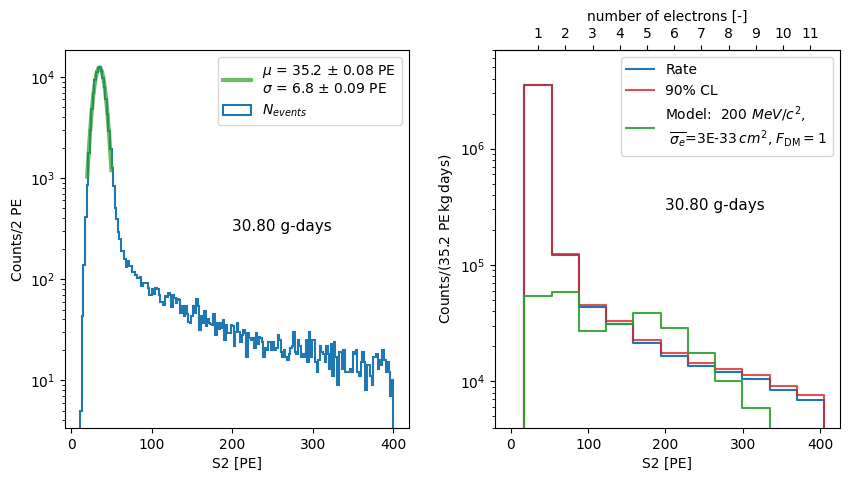

In [23]:
f, axes = plt.subplots(1,2,figsize=(10,5), dpi=100)
bins_ =200

h,bins,_=axes[0].hist(s2_area, bins=bins_,histtype="step", label=r"$N_{events}$", color="tab:blue", linewidth=1.5)

upper_end_peak = 50
lower_end_peak = 20

xdata=np.array((bins+(bins[1]-bins[0])/2)[:-1])
ydata=h
init  = [max(h), bins[np.argmax(h)], 10]

a = xdata>lower_end_peak 
b = xdata<upper_end_peak

popt, pcov = curve_fit(func, xdata[a&b], ydata[a&b],p0=init)
perr = np.sqrt(np.diag(pcov))
x_plot = np.linspace(lower_end_peak, upper_end_peak,200)
axes[0].plot(x_plot, func(x_plot, *popt), linewidth=3, alpha =0.7, color="tab:green", 
             label="$\mu$ = {:.1f} $\pm$ {:.2f} PE \n$\sigma$ = {:.1f} $\pm$ {:.2f} PE".format(popt[1],perr[1],popt[2],perr[2]))
axes[0].set_xlabel("S2 [PE]")
axes[0].set_ylabel("Counts/{} PE".format(int(400/bins_)))
axes[0].set_yscale("log")
axes[0].text(200,3e2, "{:.2f} g-days".format(exposure/(nu.g*nu.day)), fontsize=11)
axes[0].legend()

# handles, labels = axes[0].get_legend_handles_labels()
# order = [0,1]
# axes[0].legend([handles[i] for i in order],[labels[i] for i in order])


#---------------------------------second plot--------------------------------------------------

mu_tot, std_tot = popt[1],popt[2]
s2_limit_up = 400
number_of_peaks = int(np.ceil(s2_limit_up/mu_tot))
rebins = [i*mu_tot-0.5*mu_tot for i in range(1,number_of_peaks+2)]

#---------------normal ------------------------
h,_ = np.histogram(s2_area,bins=rebins)
new_bins = np.concatenate(([0],rebins[:-1]))
n_events = np.concatenate(([0],h))
poisson_level = poisson_limit(n_events)/(exposure/(nu.kg*nu.day))
rate = n_events/((exposure/(nu.kg*nu.day)))
axes[1].step(new_bins,rate,where="post", label="Rate".format(exposure/(nu.g*nu.day)), zorder=0, 
             color="tab:blue", linewidth=1.5)
axes[1].step(new_bins,poisson_level,where="post", label="90% CL",alpha=0.8,color="tab:red", linewidth=1.5)

axes[1].step(new_bins,np.concatenate([[0],data["rate"][3],[0]]),where="post", zorder=10,
             alpha=0.9,color="tab:green",label="Model:  {:.0f} $MeV/c^2$,".format(200)+
             "\n $\overline{\sigma_e}$"+"={:.0E}$\,cm^2$,".format(3.1e-33)+" $F_{\mathrm{DM}}=1$") #linestyle="--"

# handl, lab = axes[1].get_legend_handles_labels()
# order = [0,1,2]
# plt.legend([handl[i] for i in order],[lab[i] for i in order], fontsize=9)

secax = axes[1].secondary_xaxis('top', functions=(pe_to_electrons,electrons_to_pe))
secax.set_xlabel('number of electrons [-]')
secax.set_xticks(np.arange(1, 12))
axes[1].text(200,3e5, "{:.2f} g-days".format(exposure/( nu.g*nu.day)), fontsize=11)
axes[1].set_yscale("log")
axes[1].set_xlabel("S2 [PE]")
axes[1].set_ylabel("Counts/({:.1f} PE$\,$kg$\,$days)".format(popt[1]))
axes[1].set_ylim(4e3,7e6)
axes[1].legend()

plt.subplots_adjust(wspace=0.25, hspace=0.3)
plt.show()

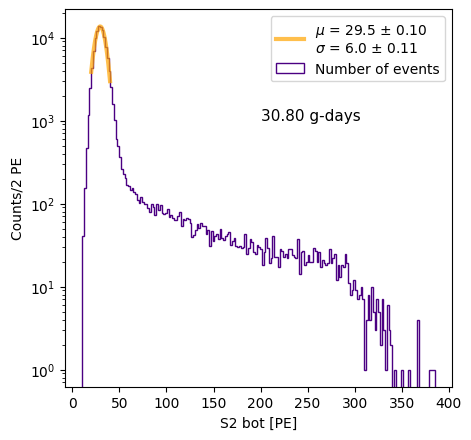

In [24]:
f, axes = plt.subplots(1,1,figsize=(5,5), dpi=100)


s2_bot = flat((pulses.s2.area_pe_bot)[pulses["s2","final_selection"]])
bins_ =200

h,bins,_=axes.hist(s2_bot, bins=bins_,histtype="step", label="Number of events", color="indigo") 
upper_end_peak = 40
lower_end_peak = 20

xdata=np.array((bins+(bins[1]-bins[0])/2)[:-1])
ydata=h
init  = [max(h), bins[np.argmax(h)], 10]

a = xdata>lower_end_peak 
b = xdata<upper_end_peak

popt, pcov = curve_fit(func, xdata[a&b], ydata[a&b],p0=init)
perr = np.sqrt(np.diag(pcov))
x_plot = np.linspace(lower_end_peak, upper_end_peak,200)
axes.plot(x_plot, func(x_plot, *popt), linewidth=3, alpha =0.7, color="orange",
             label="$\mu$ = {:.1f} $\pm$ {:.2f}  \n$\sigma$ = {:.1f} $\pm$ {:.2f}".format(popt[1],perr[1],popt[2],perr[2]))
axes.set_xlabel("S2 bot [PE]")
axes.set_ylabel("Counts/{} PE".format(int(400/bins_)))
axes.set_yscale("log")
axes.text(200,1e3, "{:.2f} g-days".format(exposure/(nu.g*nu.day)), fontsize=11)
axes.legend()
plt.show()
mu_bot, std_bot = popt[1],popt[2]

# Cut in Time

In [25]:
def return_sel(name, pos_array):
    intervals = cuts[name]
    sel = ak.ones_like(pos_array)==0 # an array of trues
    for intr in intervals: 
            sel = sel|((intr[0]*1e12<pos_array)&(pos_array<intr[1]*1e12))  
    return sel

def return_time(name):
    intervals = cuts[name]
    t = 0
    for intr in intervals:
        t += (intr[1]-intr[0])*1e12*10*nu.ns/nu.hour
    return float(t)

cuts = {
    "191031_0505":[(0.05,0.35),(0.62,1.0)], 
    "191101_2340":[(0,0.4),(0.5,0.75)], 
    "191102_0258":[(0,0.7),(0.8,1)], 
    "191102_0616":[(0.45,0.6),(0.85, 1.19168873705401)],
    "191102_0936":[(0,0.5),(0.6,0.9)],
    "191102_2024":[(0.65,1.1377409241290)],
    "191103_2021":[(0.2,0.55),(0.7,1)],
    "191106_0250":[(0,0.3),(0.5,1.1658334013550)], 
    "191106_0605":[(0.0,0.5),(0.7,1.1762496822230)]}

t_post_tcut_h = 0
pulses_tcut = ak.Array([])
units=10*nu.ns/nu.hour

for i,name in enumerate(stable): 
    df_cut = ak.Array(pulses[pulses.file==name])
    if name in cuts.keys() and name in date:
        t_post_tcut_h +=return_time(name)
        #apply the cut: 
        df_cut["s2"] = df_cut.s2[(df_cut.s2.final_selection)&(return_sel(name,df_cut.s2.pulse_time))]
        pulses_tcut = ak.concatenate([pulses_tcut,df_cut])

In [26]:
t_post_tcut_h

16.531979846558364

In [27]:
print(t_corr_sec/nu.hour)
print(time_sec/nu.hour)

30.174969089028306
30.216111111111115


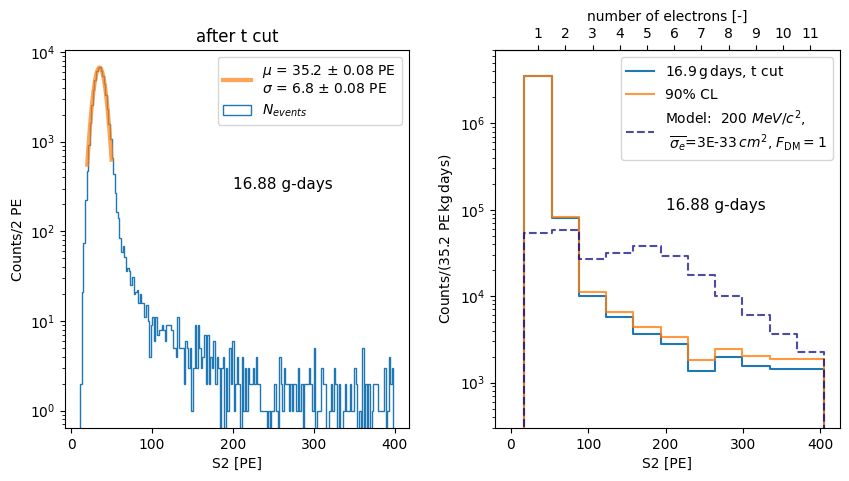

In [28]:
f, axes = plt.subplots(1,2,figsize=(10,5), dpi=100)
bins_ =200

s2_area_tcut = flat((pulses_tcut.s2.area_pe_bot+pulses_tcut.s2.area_pe_top)[pulses_tcut["s2","final_selection"]])
exp = exposure/(t_corr_sec/(nu.hour)/t_post_tcut_h)

h,bins,_=axes[0].hist(s2_area_tcut, bins=bins_,histtype="step", label=r"$N_{events}$")

upper_end_peak = 50
lower_end_peak = 20

xdata=np.array((bins+(bins[1]-bins[0])/2)[:-1])
ydata=h
init  = [max(h), bins[np.argmax(h)], 10]

a = xdata>lower_end_peak 
b = xdata<upper_end_peak

popt, pcov = curve_fit(func, xdata[a&b], ydata[a&b],p0=init)
perr = np.sqrt(np.diag(pcov))
x_plot = np.linspace(lower_end_peak, upper_end_peak,200)
axes[0].plot(x_plot, func(x_plot, *popt), linewidth=3, alpha =0.7,
             label="$\mu$ = {:.1f} $\pm$ {:.2f} PE \n$\sigma$ = {:.1f} $\pm$ {:.2f} PE".format(popt[1],perr[1],popt[2],perr[2]))
axes[0].set_xlabel("S2 [PE]")
axes[0].set_ylabel("Counts/{} PE".format(int(400/bins_)))
axes[0].set_yscale("log")
axes[0].text(200,3e2, "{:.2f} g-days".format(exp/(nu.g*nu.day)), fontsize=11)
axes[0].legend()
axes[0].set_title("after t cut")
# handles, labels = axes[0].get_legend_handles_labels()
# order = [0,1]
# axes[0].legend([handles[i] for i in order],[labels[i] for i in order])


#---------------------------------second plot--------------------------------------------------

mu_tot, std_tot = popt[1],popt[2]
s2_limit_up = 400
number_of_peaks = int(np.ceil(s2_limit_up/mu_tot))
rebins = [i*mu_tot-0.5*mu_tot for i in range(1,number_of_peaks+2)]

#---------------t cut ------------------------
h,_=np.histogram(s2_area_tcut,bins=rebins)
new_bins = np.concatenate(([0],rebins[:-1]))
n_events    = np.concatenate(([0],h))
poisson_level = poisson_limit(n_events)/(exp/(nu.kg*nu.day))
rate = n_events/(exp/(nu.kg*nu.day))
axes[1].step(new_bins,rate,where="post", label="{:.1f}$\,$g$\,$days, t cut".format(exp/(nu.g*nu.day)), zorder=0)
axes[1].step(new_bins,poisson_level,where="post", label="90% CL",alpha=0.8)
axes[1].step(new_bins,np.concatenate([[0],data["rate"][3],[0]]),where="post", zorder=10,
             alpha=0.7,linestyle="--",color="navy",label="Model:  {:.0f} $MeV/c^2$,".format(200)+
             "\n $\overline{\sigma_e}$"+"={:.0E}$\,cm^2$,".format(3.1e-33)+" $F_{\mathrm{DM}}=1$")


# handl, lab = axes[1].get_legend_handles_labels()
# order = [0,1,2]
# plt.legend([handl[i] for i in order],[lab[i] for i in order], fontsize=9)

secax = axes[1].secondary_xaxis('top', functions=(pe_to_electrons,electrons_to_pe))
secax.set_xlabel('number of electrons [-]')
secax.set_xticks(np.arange(1, 12))
axes[1].text(200,1e5, "{:.2f} g-days".format(exp/(nu.g*nu.day)), fontsize=11)
axes[1].set_yscale("log")
axes[1].set_xlabel("S2 [PE]")
axes[1].set_ylabel("Counts/({:.1f} PE$\,$kg$\,$days)".format(popt[1]))
axes[1].set_ylim(3e2,7e6)
axes[1].legend()

plt.subplots_adjust(wspace=0.25, hspace=0.3)
plt.show()

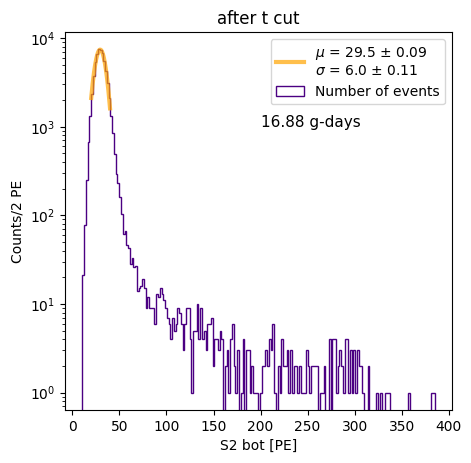

In [29]:
f, axes = plt.subplots(1,1,figsize=(5,5), dpi=100)


s2_bot = flat((pulses_tcut.s2.area_pe_bot)[pulses_tcut["s2","final_selection"]])
bins_ =200

h,bins,_=axes.hist(s2_bot, bins=bins_,histtype="step", label="Number of events", color="indigo") 
upper_end_peak = 40
lower_end_peak = 20

xdata=np.array((bins+(bins[1]-bins[0])/2)[:-1])
ydata=h
init  = [max(h), bins[np.argmax(h)], 10]

a = xdata>lower_end_peak 
b = xdata<upper_end_peak

popt, pcov = curve_fit(func, xdata[a&b], ydata[a&b],p0=init)
perr = np.sqrt(np.diag(pcov))
x_plot = np.linspace(lower_end_peak, upper_end_peak,200)
axes.plot(x_plot, func(x_plot, *popt), linewidth=3, alpha =0.7, color="orange",
             label="$\mu$ = {:.1f} $\pm$ {:.2f}  \n$\sigma$ = {:.1f} $\pm$ {:.2f}".format(popt[1],perr[1],popt[2],perr[2]))
axes.set_xlabel("S2 bot [PE]")
axes.set_ylabel("Counts/{} PE".format(int(400/bins_)))
axes.set_yscale("log")
axes.text(200,1e3, "{:.2f} g-days".format(exp/(nu.g*nu.day)), fontsize=11)
axes.legend()
axes.set_title("after t cut")
plt.show()
mu_bot, std_bot = popt[1],popt[2]

In [30]:
n_events/(exp/(nu.kg*nu.day))

array([0.00000000e+00, 3.49334062e+06, 7.97563646e+04, 1.01324951e+04,
       5.74767263e+03, 3.67377014e+03, 2.78495478e+03, 1.36285021e+03,
       1.95539378e+03, 1.54061328e+03, 1.42210457e+03, 1.42210457e+03,
       0.00000000e+00])

# Cut in Space

In [31]:
pulses_ycut = ak.Array(pulses)
pulses_ycut["s2"] = pulses_ycut.s2[(pulses_ycut.s2.y_corr>0)]

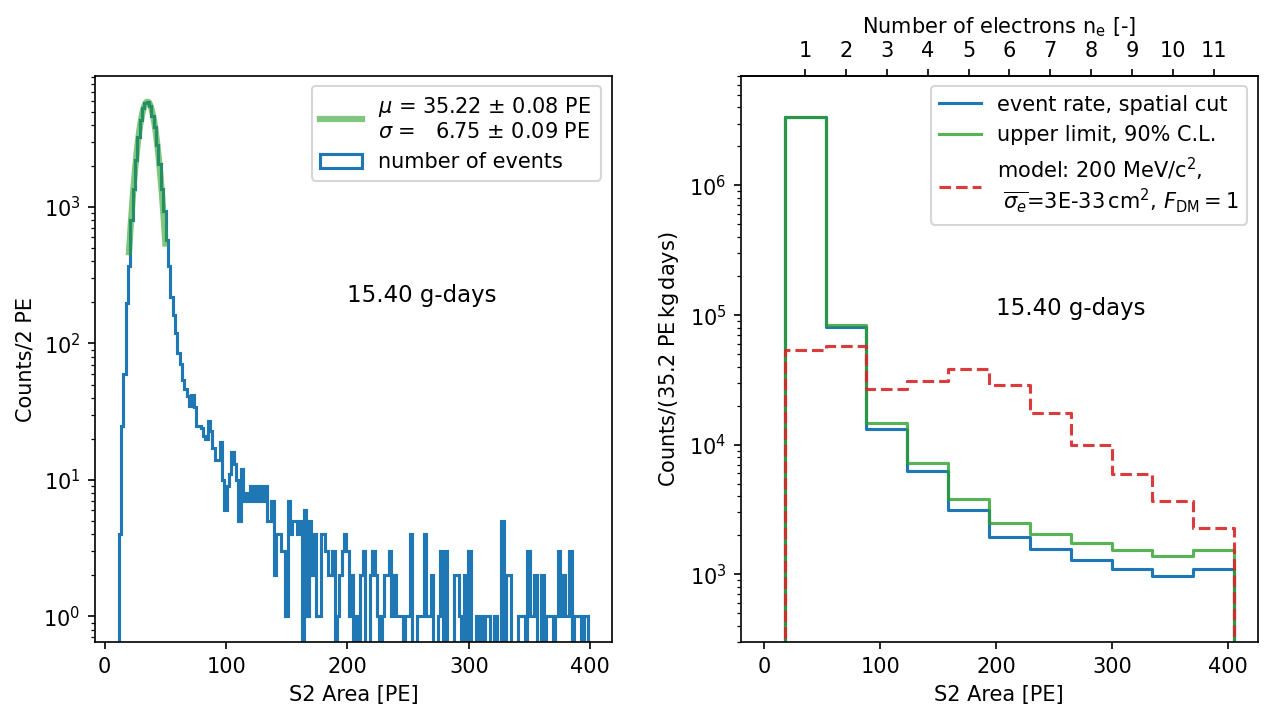

In [42]:
f, axes = plt.subplots(1,2,figsize=(10,5), dpi=150)
bins_ =200

s2_area_ycut = flat((pulses_ycut.s2.area_pe_bot+pulses_ycut.s2.area_pe_top)[pulses_ycut["s2","final_selection"]])
exp = exposure/2

h,bins,_=axes[0].hist(s2_area_ycut, bins=bins_,histtype="step", label=r"number of events",linewidth=1.5, color="tab:blue")

upper_end_peak = 50
lower_end_peak = 20

xdata=np.array((bins+(bins[1]-bins[0])/2)[:-1])
ydata=h
init  = [max(h), bins[np.argmax(h)], 10]

a = xdata>lower_end_peak 
b = xdata<upper_end_peak

popt, pcov = curve_fit(func, xdata[a&b], ydata[a&b],p0=init)
perr = np.sqrt(np.diag(pcov))
x_plot = np.linspace(lower_end_peak, upper_end_peak,200)
axes[0].plot(x_plot, func(x_plot, *popt), linewidth=3, alpha =0.6, color="tab:green",
             label="$\mu$ = {:.2f} $\pm$ {:.2f} PE \n$\sigma$ =   {:.2f} $\pm$ {:.2f} PE".format(popt[1],perr[1],popt[2],perr[2]))
axes[0].set_xlabel("S2 Area [PE]")
axes[0].set_ylabel("Counts/{} PE".format(int(400/bins_)))
axes[0].set_yscale("log")
axes[0].text(200,2e2, "{:.2f} g-days".format(exp/(nu.g*nu.day)), fontsize=11)
axes[0].legend()
#axes[0].set_title("after y cut")
# handles, labels = axes[0].get_legend_handles_labels()
# order = [0,1]
# axes[0].legend([handles[i] for i in order],[labels[i] for i in order])


#---------------------------------second plot--------------------------------------------------

mu_tot, std_tot = popt[1],popt[2]
s2_limit_up = 400
number_of_peaks = int(np.ceil(s2_limit_up/mu_tot))
rebins = [i*mu_tot-0.5*mu_tot for i in range(1,number_of_peaks+2)]


#---------------y cut ------------------------
h,_=np.histogram(s2_area_ycut,bins=rebins)
new_bins = np.concatenate(([0],rebins[:-1]))
n_events    = np.concatenate(([0],h))
poisson_level = poisson_limit(n_events)/(exp/(nu.kg*nu.day))
rate = n_events/(exp/(nu.kg*nu.day))
axes[1].step(new_bins,rate,where="post", label="event rate, spatial cut", color="tab:blue",linewidth=1.5,zorder=0)
axes[1].step(new_bins,poisson_level,where="post", label="upper limit, 90% C.L.",alpha=0.8,color="tab:green", linewidth=1.5)
axes[1].step(new_bins,np.concatenate([[0],data["rate"][3],[0]]),where="post", zorder=10,linewidth=1.5,
             alpha=0.9,linestyle="--",color="tab:red",label="model: 200 $\mathrm{MeV/c^2}$,"+
             "\n $\overline{\sigma_e}$"+"={:.0E}".format(3.1e-33)+"$\,\mathrm{cm^2}$, $F_{\mathrm{DM}}=1$")


# handl, lab = axes[1].get_legend_handles_labels()
# order = [0,1,2]
# plt.legend([handl[i] for i in order],[lab[i] for i in order], fontsize=9)

secax = axes[1].secondary_xaxis('top', functions=(pe_to_electrons,electrons_to_pe))
secax.set_xlabel('Number of electrons $\mathrm{n_e}$ [-]')
secax.set_xticks(np.arange(1, 12))
axes[1].text(200,1e5, "{:.2f} g-days".format(exp/(nu.g*nu.day)), fontsize=11)
axes[1].set_yscale("log")
axes[1].set_xlabel("S2 Area [PE]")
axes[1].set_ylabel("Counts/({:.1f} PE$\,$kg$\,$days)".format(popt[1]))
axes[1].set_ylim(3e2,7e6)
axes[1].legend()

plt.subplots_adjust(wspace=0.25, hspace=0.3)
plt.show()

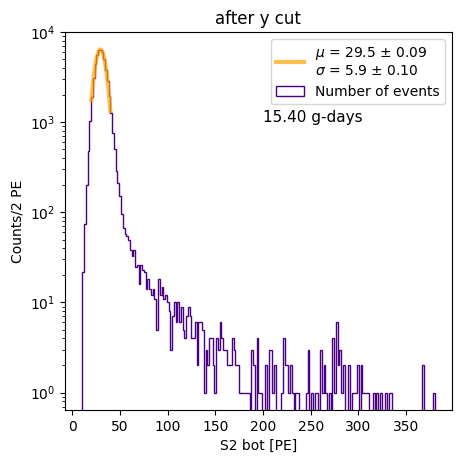

In [33]:
f, axes = plt.subplots(1,1,figsize=(5,5), dpi=100)


s2_bot = flat((pulses_ycut.s2.area_pe_bot)[pulses_ycut["s2","final_selection"]])
bins_ =200

h,bins,_=axes.hist(s2_bot, bins=bins_,histtype="step", label="Number of events", color="indigo") 
upper_end_peak = 40
lower_end_peak = 20

xdata=np.array((bins+(bins[1]-bins[0])/2)[:-1])
ydata=h
init  = [max(h), bins[np.argmax(h)], 10]

a = xdata>lower_end_peak 
b = xdata<upper_end_peak

popt, pcov = curve_fit(func, xdata[a&b], ydata[a&b],p0=init)
perr = np.sqrt(np.diag(pcov))
x_plot = np.linspace(lower_end_peak, upper_end_peak,200)
axes.plot(x_plot, func(x_plot, *popt), linewidth=3, alpha =0.7, color="orange",
             label="$\mu$ = {:.1f} $\pm$ {:.2f}  \n$\sigma$ = {:.1f} $\pm$ {:.2f}".format(popt[1],perr[1],popt[2],perr[2]))
axes.set_xlabel("S2 bot [PE]")
axes.set_ylabel("Counts/{} PE".format(int(400/bins_)))
axes.set_yscale("log")
axes.text(200,1e3, "{:.2f} g-days".format(exp/(nu.g*nu.day)), fontsize=11)
axes.legend()
axes.set_title("after y cut")
plt.show()
mu_bot, std_bot = popt[1],popt[2]

In [34]:
n_events/(exp/(nu.kg*nu.day))

array([0.00000000e+00, 3.34798375e+06, 8.10943799e+04, 1.33101264e+04,
       6.29796225e+03, 3.11651740e+03, 1.94782338e+03, 1.55825870e+03,
       1.29854892e+03, 1.10376658e+03, 9.73911689e+02, 1.10376658e+03,
       0.00000000e+00])

# Both

In [35]:
pulses_both = ak.Array(pulses_tcut)
pulses_both["s2"] = pulses_both.s2[(pulses_both.s2.y_corr>0)]

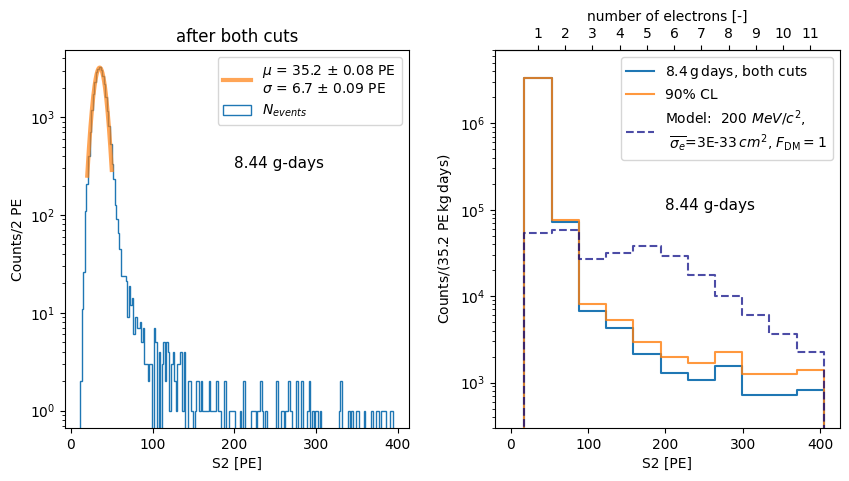

In [36]:
f, axes = plt.subplots(1,2,figsize=(10,5), dpi=100)
bins_ =200

s2_area_ycut = flat((pulses_both.s2.area_pe_bot+pulses_both.s2.area_pe_top)[pulses_both.s2.final_selection])
exp = exposure/(2*(t_corr_sec/(nu.hour)/t_post_tcut_h))

h,bins,_=axes[0].hist(s2_area_ycut, bins=bins_,histtype="step", label=r"$N_{events}$")

upper_end_peak = 50
lower_end_peak = 20

xdata=np.array((bins+(bins[1]-bins[0])/2)[:-1])
ydata=h
init  = [max(h), bins[np.argmax(h)], 10]

a = xdata>lower_end_peak 
b = xdata<upper_end_peak

popt, pcov = curve_fit(func, xdata[a&b], ydata[a&b],p0=init)
perr = np.sqrt(np.diag(pcov))
x_plot = np.linspace(lower_end_peak, upper_end_peak,200)
axes[0].plot(x_plot, func(x_plot, *popt), linewidth=3, alpha =0.7,
             label="$\mu$ = {:.1f} $\pm$ {:.2f} PE \n$\sigma$ = {:.1f} $\pm$ {:.2f} PE".format(popt[1],perr[1],popt[2],perr[2]))
axes[0].set_xlabel("S2 [PE]")
axes[0].set_ylabel("Counts/{} PE".format(int(400/bins_)))
axes[0].set_yscale("log")
axes[0].text(200,3e2, "{:.2f} g-days".format(exp/(nu.g*nu.day)), fontsize=11)
axes[0].legend()
axes[0].set_title("after both cuts")
# handles, labels = axes[0].get_legend_handles_labels()
# order = [0,1]
# axes[0].legend([handles[i] for i in order],[labels[i] for i in order])


#---------------------------------second plot--------------------------------------------------

mu_tot, std_tot = popt[1],popt[2]
s2_limit_up = 400
number_of_peaks = int(np.ceil(s2_limit_up/mu_tot))
rebins = [i*mu_tot-0.5*mu_tot for i in range(1,number_of_peaks+2)]


#---------------y cut ------------------------
h,_=np.histogram(s2_area_ycut,bins=rebins)
new_bins = np.concatenate(([0],rebins[:-1]))
n_events    = np.concatenate(([0],h))
poisson_level = poisson_limit(n_events)/(exp/(nu.kg*nu.day))
rate = n_events/(exp/(nu.kg*nu.day))
axes[1].step(new_bins,rate,where="post", label="{:.1f}$\,$g$\,$days, both cuts".format(exp/(nu.g*nu.day)), zorder=0)
axes[1].step(new_bins,poisson_level,where="post", label="90% CL",alpha=0.8)
axes[1].step(new_bins,np.concatenate([[0],data["rate"][3],[0]]),where="post", zorder=10,
             alpha=0.7,linestyle="--",color="navy",label="Model:  {:.0f} $MeV/c^2$,".format(200)+
             "\n $\overline{\sigma_e}$"+"={:.0E}$\,cm^2$,".format(3.1e-33)+" $F_{\mathrm{DM}}=1$")


# handl, lab = axes[1].get_legend_handles_labels()
# order = [0,1,2]
# plt.legend([handl[i] for i in order],[lab[i] for i in order], fontsize=9)

secax = axes[1].secondary_xaxis('top', functions=(pe_to_electrons,electrons_to_pe))
secax.set_xlabel('number of electrons [-]')
secax.set_xticks(np.arange(1, 12))
axes[1].text(200,1e5, "{:.2f} g-days".format(exp/(nu.g*nu.day)), fontsize=11)
axes[1].set_yscale("log")
axes[1].set_xlabel("S2 [PE]")
axes[1].set_ylabel("Counts/({:.1f} PE$\,$kg$\,$days)".format(popt[1]))
axes[1].set_ylim(3e2,7e6)
axes[1].legend()

plt.subplots_adjust(wspace=0.25, hspace=0.3)
plt.show()

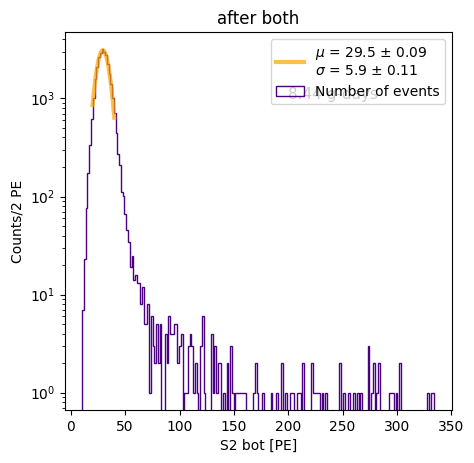

In [37]:
f, axes = plt.subplots(1,1,figsize=(5,5), dpi=100)


s2_bot = flat((pulses_both.s2.area_pe_bot)[pulses_both["s2","final_selection"]])
bins_ =200

h,bins,_=axes.hist(s2_bot, bins=bins_,histtype="step", label="Number of events", color="indigo") 
upper_end_peak = 40
lower_end_peak = 20

xdata=np.array((bins+(bins[1]-bins[0])/2)[:-1])
ydata=h
init  = [max(h), bins[np.argmax(h)], 10]

a = xdata>lower_end_peak 
b = xdata<upper_end_peak

popt, pcov = curve_fit(func, xdata[a&b], ydata[a&b],p0=init)
perr = np.sqrt(np.diag(pcov))
x_plot = np.linspace(lower_end_peak, upper_end_peak,200)
axes.plot(x_plot, func(x_plot, *popt), linewidth=3, alpha =0.7, color="orange",
             label="$\mu$ = {:.1f} $\pm$ {:.2f}  \n$\sigma$ = {:.1f} $\pm$ {:.2f}".format(popt[1],perr[1],popt[2],perr[2]))
axes.set_xlabel("S2 bot [PE]")
axes.set_ylabel("Counts/{} PE".format(int(400/bins_)))
axes.set_yscale("log")
axes.text(200,1e3, "{:.2f} g-days".format(exp/(nu.g*nu.day)), fontsize=11)
axes.legend()
axes.set_title("after both")
plt.show()
mu_bot, std_bot = popt[1],popt[2]

In [38]:
pulses

<Array [{s1s_per_waveform: 0, ... ] type='163791 * ?{"s1s_per_waveform": int32, ...'>

In [39]:
exp/(nu.kg*nu.day)

0.008438198046680834

In [40]:
n_events/(exp/(nu.kg*nu.day))

array([0.00000000e+00, 3.34870073e+06, 7.11052285e+04, 6.75499670e+03,
       4.26631371e+03, 2.13315685e+03, 1.30359586e+03, 1.06657843e+03,
       1.54061328e+03, 7.11052285e+02, 7.11052285e+02, 8.29560999e+02,
       0.00000000e+00])

# Comparison, in blob

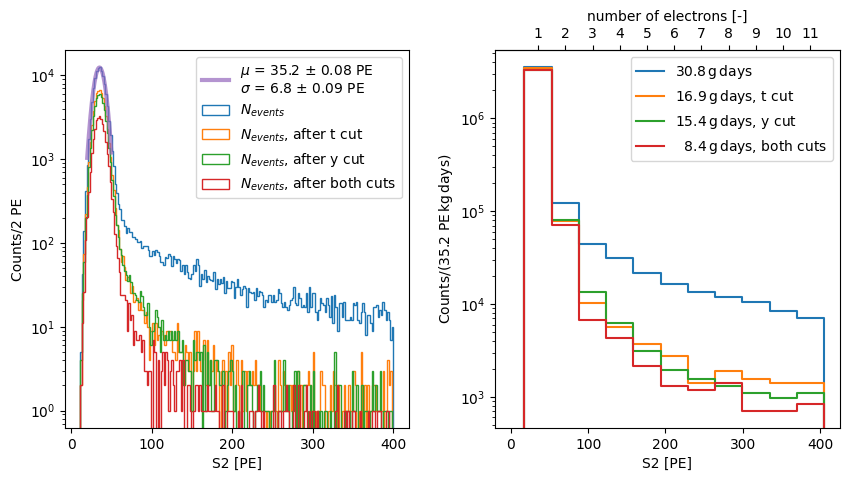

In [41]:
f, axes = plt.subplots(1,2,figsize=(10,5), dpi=100)
bins_ =200

s2_area_tcut  = flat((pulses_tcut.s2.area_pe_bot+pulses_tcut.s2.area_pe_top)[pulses_tcut.s2.final_selection])
s2_area_xycut = flat((pulses_ycut.s2.area_pe_bot+pulses_ycut.s2.area_pe_top)[pulses_ycut.s2.final_selection])
s2_area_both  = flat((pulses_both.s2.area_pe_bot+pulses_both.s2.area_pe_top)[pulses_both.s2.final_selection])

h,bins,_=axes[0].hist(s2_area, bins=bins_,histtype="step", label=r"$N_{events}$")
axes[0].hist(s2_area_tcut,     bins=bins_,histtype="step", label=r"$N_{events}$, after t cut") 
axes[0].hist(s2_area_xycut,    bins=bins_,histtype="step", label=r"$N_{events}$, after y cut")
axes[0].hist(s2_area_both,     bins=bins_,histtype="step", label=r"$N_{events}$, after both cuts")


upper_end_peak = 50
lower_end_peak = 20

xdata=np.array((bins+(bins[1]-bins[0])/2)[:-1])
ydata=h
init  = [max(h), bins[np.argmax(h)], 10]

a = xdata>lower_end_peak 
b = xdata<upper_end_peak

popt, pcov = curve_fit(func, xdata[a&b], ydata[a&b],p0=init)
perr = np.sqrt(np.diag(pcov))
x_plot = np.linspace(lower_end_peak, upper_end_peak,200)
axes[0].plot(x_plot, func(x_plot, *popt), linewidth=3, alpha =0.7,
             label="$\mu$ = {:.1f} $\pm$ {:.2f} PE \n$\sigma$ = {:.1f} $\pm$ {:.2f} PE".format(popt[1],perr[1],popt[2],perr[2]))
axes[0].set_xlabel("S2 [PE]")
axes[0].set_ylabel("Counts/{} PE".format(int(400/bins_)))
axes[0].set_yscale("log")
# axes[0].text(200,3e2, "{:.2f} g-days".format(exposure/(nu.g*nu.day)), fontsize=11)
axes[0].legend()

handles, labels = axes[0].get_legend_handles_labels()
order = [0,1,2,3,4]
axes[0].legend([handles[i] for i in order],[labels[i] for i in order])


#---------------------------------second plot--------------------------------------------------

mu_tot, std_tot = popt[1],popt[2]
s2_limit_up = 400
number_of_peaks = int(np.ceil(s2_limit_up/mu_tot))
rebins = [i*mu_tot-0.5*mu_tot for i in range(1,number_of_peaks+2)]

#---------------normal ------------------------
h,_=np.histogram(s2_area,bins=rebins)
new_bins = np.concatenate(([0],rebins[:-1]))
n_events    = np.concatenate(([0],h))
poisson_level = poisson_limit(n_events)/(exposure/(nu.kg*nu.day))
rate = n_events/((exposure/(nu.kg*nu.day)))
axes[1].step(new_bins,rate,where="post", label="{:.1f}$\,$g$\,$days ".format(exposure/(nu.g*nu.day)), zorder=0)


#---------------t cut ------------------------
h,_=np.histogram(s2_area_tcut,bins=rebins)
new_bins = np.concatenate(([0],rebins[:-1]))
n_events    = np.concatenate(([0],h))
exp = exposure/(t_corr_sec/(nu.hour)/t_post_tcut_h)
poisson_level = poisson_limit(n_events)/(exp/(nu.kg*nu.day))
rate = n_events/(exp/(nu.kg*nu.day))

axes[1].step(new_bins,rate,where="post", label="{:.1f}$\,$g$\,$days, t cut".format(exp/(nu.g*nu.day)), zorder=0)


#---------------y cut ------------------------
h,_=np.histogram(s2_area_xycut,bins=rebins)
new_bins = np.concatenate(([0],rebins[:-1]))
n_events    = np.concatenate(([0],h))
exp  = exposure/2
poisson_level = poisson_limit(n_events)/(exp/(nu.kg*nu.day))
rate = n_events/(exp/(nu.kg*nu.day))

axes[1].step(new_bins,rate,where="post", label="{:.1f}$\,$g$\,$days, y cut".format(exp/(nu.g*nu.day)), zorder=0)


#---------------both ------------------------
h,_=np.histogram(s2_area_both,bins=rebins)
new_bins = np.concatenate(([0],rebins[:-1]))
n_events    = np.concatenate(([0],h))
exp =  exposure/(2*t_corr_sec/(nu.hour)/t_post_tcut_h)
poisson_level = poisson_limit(n_events)/(exp/(nu.kg*nu.day))
rate = n_events/(exp/(nu.kg*nu.day))

axes[1].step(new_bins,rate,where="post", label="  {:.1f}$\,$g$\,$days, both cuts".format(exp/(nu.g*nu.day)), zorder=0)


#----------------------------------------------

# handl, lab = axes[1].get_legend_handles_labels()
# order = [0,1,2]
# plt.legend([handl[i] for i in order],[lab[i] for i in order], fontsize=9)
axes[1].legend()
secax = axes[1].secondary_xaxis('top', functions=(pe_to_electrons,electrons_to_pe))
secax.set_xlabel('number of electrons [-]')
secax.set_xticks(np.arange(1, 12))
# axes[1].text(200,1e5, "{:.2f} g-days".format(exposure/( nu.g*nu.day)), fontsize=11)
axes[1].set_yscale("log")
axes[1].set_xlabel("S2 [PE]")
axes[1].set_ylabel("Counts/({:.1f} PE$\,$kg$\,$days)".format(popt[1]))
#axes[1].set_ylim(4e3,7e6)


plt.subplots_adjust(wspace=0.25, hspace=0.3)
plt.show()